In [6]:
#from __future__ import division, print_function
%matplotlib inline

import time
from sklearn import manifold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize, LabelBinarizer, LabelEncoder
from sklearn import metrics, model_selection
from sklearn.datasets import make_moons
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from metric_tools import *

sns.set(style="white", color_codes=True, context="poster")
mainpath = '/Users/jorgetil/Astro/HITS'

pos/neg: 3000 / 3000
Amount of labeled samples: 300


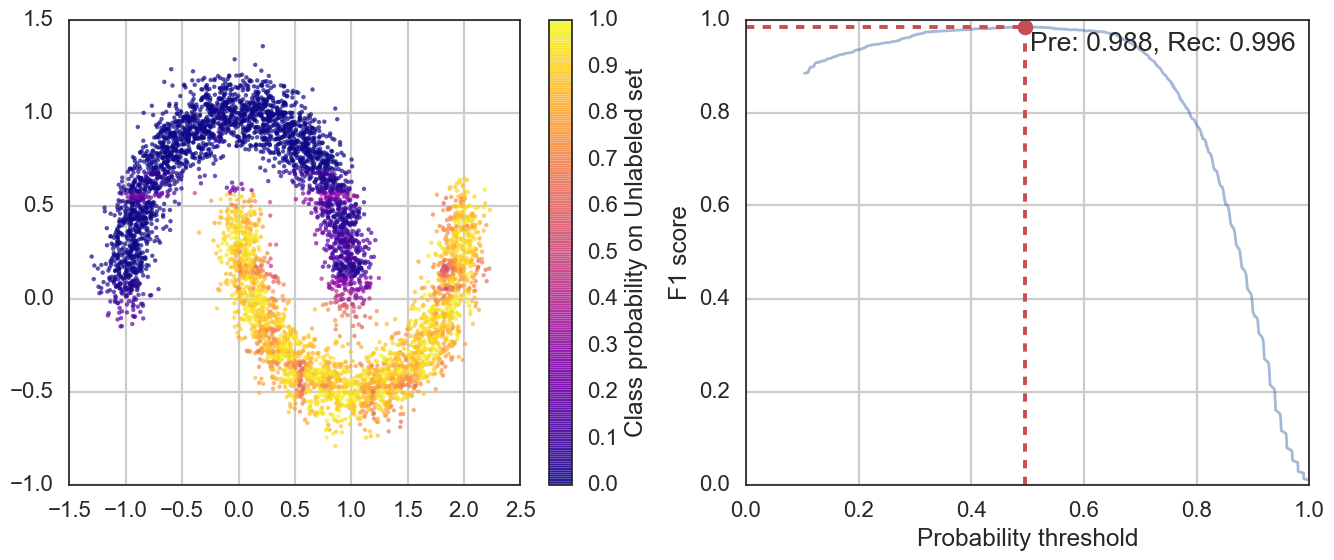

0.988235294118 0.995555555556


In [10]:
N = 6000
X, y = make_moons(n_samples=N, noise=0.1, shuffle=True)
bagging_PU(X,y)

In [11]:
table_file = '%s/tables/Blind15A_label_sample_new_PS.csv'\
              %(mainpath)
label_samp = pd.read_csv(table_file)
label_samp = label_samp.set_index('internalID')
print label_samp.shape

feat = label_samp.columns.values
FATS_feats = feat[6:-3]
FATS_feats = FATS_feats[FATS_feats!='Mean']
label_samp = label_samp[label_samp.Var_Type != 'DSCT']
label_samp = label_samp[label_samp.Var_Type != 'ZZ']
label_samp = label_samp[label_samp.Var_Type != 'LPV']
label_samp_nonnan = label_samp.dropna(subset=FATS_feats)
print label_samp_nonnan.shape

(2933, 72)
(2918, 72)


## convert into variable-nonvariable classification

In [279]:
def conv_into_binary_class(y, pos_label=None, neg_bool=False, neg_label=None):
    if type(pos_label) == str:
        pos_label = [pos_label]
    binary_class = np.zeros(shape=y.shape, dtype=np.int)
    if not neg_label:
        pos_idx = [x for x in range(len(y)) if y[x] in pos_label]
        binary_class[pos_idx] = 1
    else:
        neg_idx = np.where(y==neg_label)
        binary_class += 1
        binary_class[neg_idx] = 0
    
    return binary_class

In [280]:
print label_samp['Var_Type'].sample(100, random_state=10).values
print conv_into_binary_class(label_samp['Var_Type'].sample(100, random_state=10).values,
                             pos_label=['RRLYR','EB','ROTVAR'])
print conv_into_binary_class(label_samp['Var_Type'].sample(100, random_state=10).values,
                             pos_label='RRLYR')
print conv_into_binary_class(label_samp['Var_Type'].sample(100, random_state=10).values,
                             neg_bool=True, neg_label='NV')

['QSO' 'QSO' 'QSO' 'QSO' 'QSO' 'QSO' 'RRLYR' 'QSO' 'QSO' 'QSO' 'QSO'
 'RRLYR' 'QSO' 'QSO' 'QSO' 'QSO' 'EB' 'CV' 'NV' 'QSO' 'QSO' 'QSO' 'QSO'
 'QSO' 'QSO' 'NV' 'QSO' 'QSO' 'QSO' 'QSO' 'RRLYR' 'QSO' 'QSO' 'RRLYR' 'QSO'
 'EB' 'QSO' 'QSO' 'RRLYR' 'QSO' 'QSO' 'RRLYR' 'QSO' 'QSO' 'QSO' 'QSO' 'QSO'
 'QSO' 'QSO' 'QSO' 'QSO' 'QSO' 'QSO' 'QSO' 'QSO' 'QSO' 'QSO' 'QSO' 'NV'
 'EB' 'QSO' 'QSO' 'QSO' 'QSO' 'QSO' 'EB' 'QSO' 'QSO' 'QSO' 'QSO' 'QSO'
 'QSO' 'QSO' 'QSO' 'QSO' 'NV' 'QSO' 'QSO' 'QSO' 'QSO' 'QSO' 'QSO' 'RRLYR'
 'QSO' 'QSO' 'QSO' 'QSO' 'QSO' 'EB' 'QSO' 'QSO' 'QSO' 'QSO' 'QSO' 'QSO'
 'QSO' 'NV' 'NV' 'QSO' 'QSO']
[0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0
 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0

In [281]:
y_var = conv_into_binary_class(label_samp_nonnan['Var_Type'].values,
                             neg_bool=True, neg_label='NV')
print'Var/nonVar:',
print '%i/%i' % (y_var[y_var==1].shape[0],
                 y_var[y_var==0].shape[0])

y_periodic = conv_into_binary_class(label_samp_nonnan['Var_Type'].values,
                             pos_label=['RRLYR','EB','ROTVAR','DSCT','ZZ','LPV'])
print'Periodic/nonPeriodic:',
print '%i/%i' % (y_periodic[y_periodic==1].shape[0],
                 y_periodic[y_periodic==0].shape[0])
X_var = label_samp_nonnan[FATS_feats].values

Var/nonVar: 2772/146
Periodic/nonPeriodic: 361/2557


# Bagging PU

(2918, 62)
(2918,)
pos/neg: 361 / 2557
Amount of labeled samples: 180


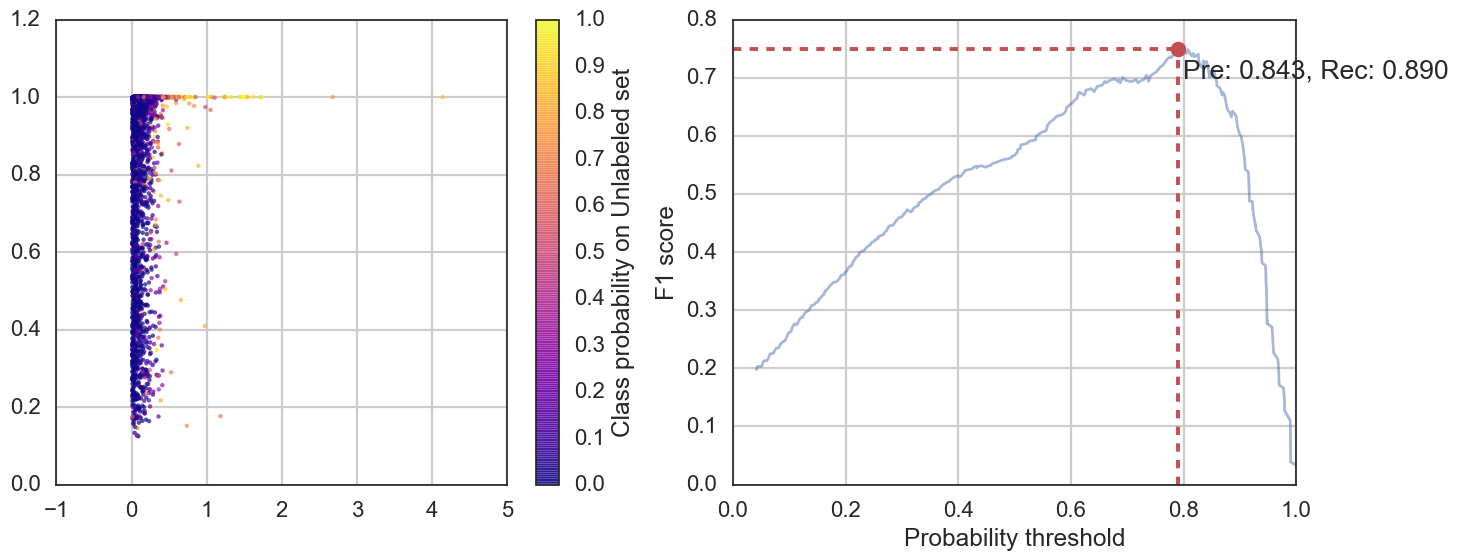

0.842931937173 0.889502762431
bagging_PU: 2.2 sec


In [282]:
t0 = time.time()
print X_var.shape
print y_periodic.shape
bagging_PU(X_var, y_periodic, known_labels_ratio=.5, K=150)
t1 = time.time()
print("bagging_PU: %.2g sec" % (t1 - t0))

# t-SNE

In [284]:
t0 = time.time()
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, method='exact')
Y = tsne.fit_transform(X_var)
t1 = time.time()
print("bagging_PU: %.2g sec" % (t1 - t0))

bagging_PU: 1.6e+02 sec


In [285]:
le = LabelEncoder()
num_classes = le.fit_transform(label_samp_nonnan['Var_Type'].values)
print num_classes

[0 0 0 ..., 1 1 6]


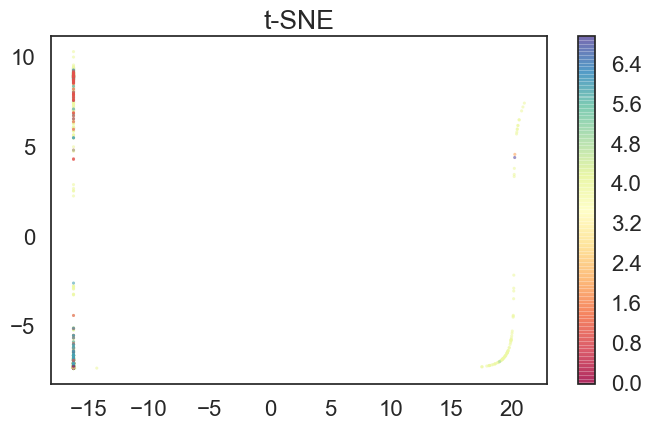

In [286]:
plt.figure(figsize=(8, 4.5))
plt.scatter(np.arcsinh(Y[:, 0]), np.arcsinh(Y[:, 1]), s=5, lw=0,
            alpha=.6, c=num_classes, cmap=plt.cm.Spectral)
plt.colorbar()
plt.title("t-SNE")
plt.axis('tight')
plt.show()

## Multiclass classification using OneVsRest

In [287]:
lb = LabelBinarizer()
lb.fit(label_samp_nonnan['Var_Type'].values)
print lb.classes_
y_bin = lb.transform(label_samp_nonnan['Var_Type'].values)

['CV' 'EB' 'MISC' 'NV' 'QSO' 'ROTVAR' 'RRLYR' 'SNe']


In [294]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_var, y_bin,
                                                                    test_size=.4)
RFC = RandomForestClassifier(n_estimators=100, criterion='gini',
                           max_features='sqrt', max_depth=10, n_jobs=2,
                            min_samples_leaf=1, oob_score=True,
                            class_weight='balanced_subsample')

classifier = OneVsRestClassifier(estimator=RFC, n_jobs=2)
classifier.fit(X_train, y_train)
predict_prob = classifier.predict_proba(X_test)
y_score = classifier.score(X_test, y_test)
prediction = classifier.predict(X_test)
prediction_class = lb.inverse_transform(prediction)

#ss = model_selection.StratifiedShuffleSplit(n_splits=3, train_size=1./3.)
#prediction_cv = model_selection.cross_val_predict(classifier, 
#                                    X_var, y_bin, cv=10, n_jobs=2, verbose=1)
#prediction_cv_class = lb.inverse_transform(prediction_cv)

In [296]:
print metrics.classification_report(lb.inverse_transform(y_test), prediction_class)

             precision    recall  f1-score   support

         CV       0.03      0.04      0.03        24
         EB       0.93      0.68      0.79        63
       MISC       0.00      0.00      0.00         1
         NV       0.75      0.81      0.78        48
        QSO       0.95      0.98      0.96       942
     ROTVAR       0.00      0.00      0.00         6
      RRLYR       0.94      0.81      0.87        79
        SNe       1.00      0.40      0.57         5

avg / total       0.92      0.91      0.91      1168



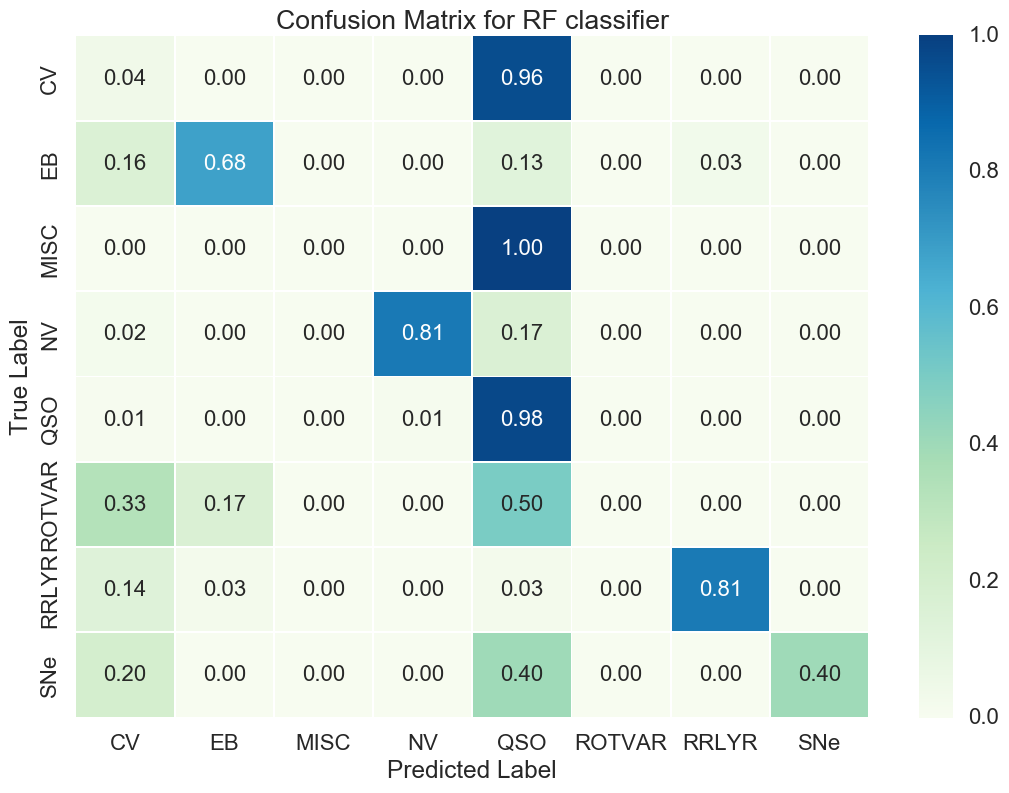

In [297]:
conf_matrix(true=lb.inverse_transform(y_test), predict=prediction_class, 
            classes=lb.classes_, save=False, normalized=True)

## BaggingPU with multiclass

CV
pos/neg: 64 / 2860
Amount of labeled samples: 32


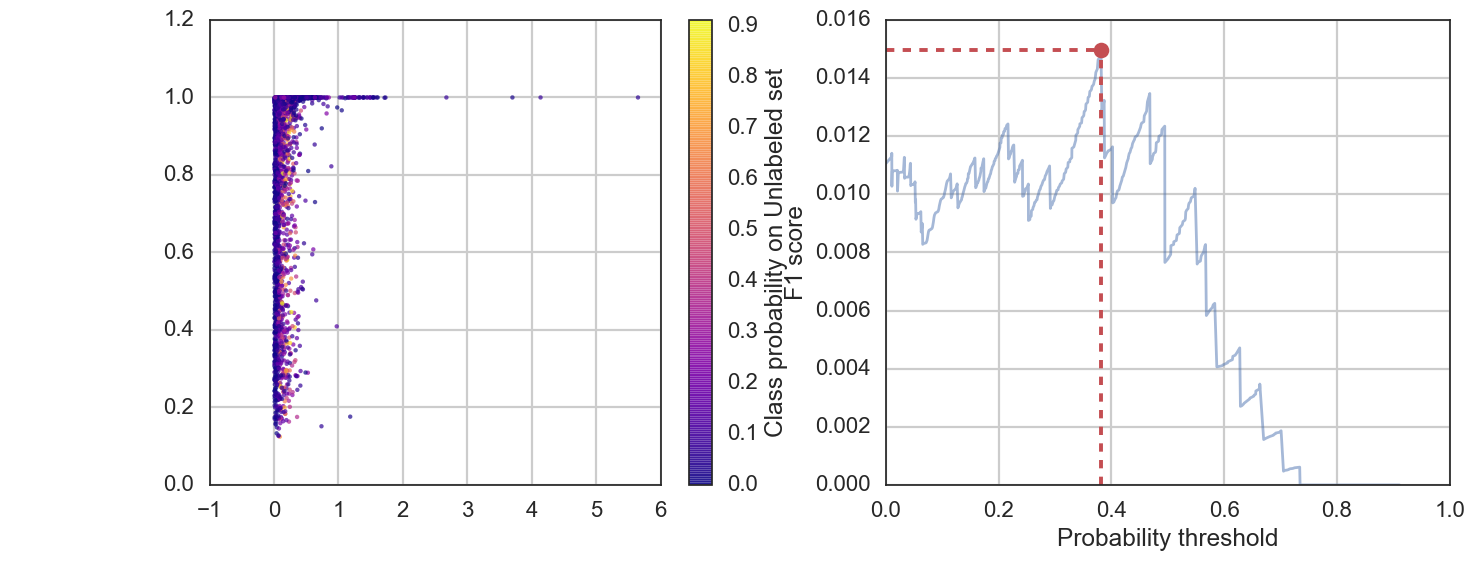

0.0368271954674 0.40625
DSCT
pos/neg: 1 / 2923
Amount of labeled samples: 0


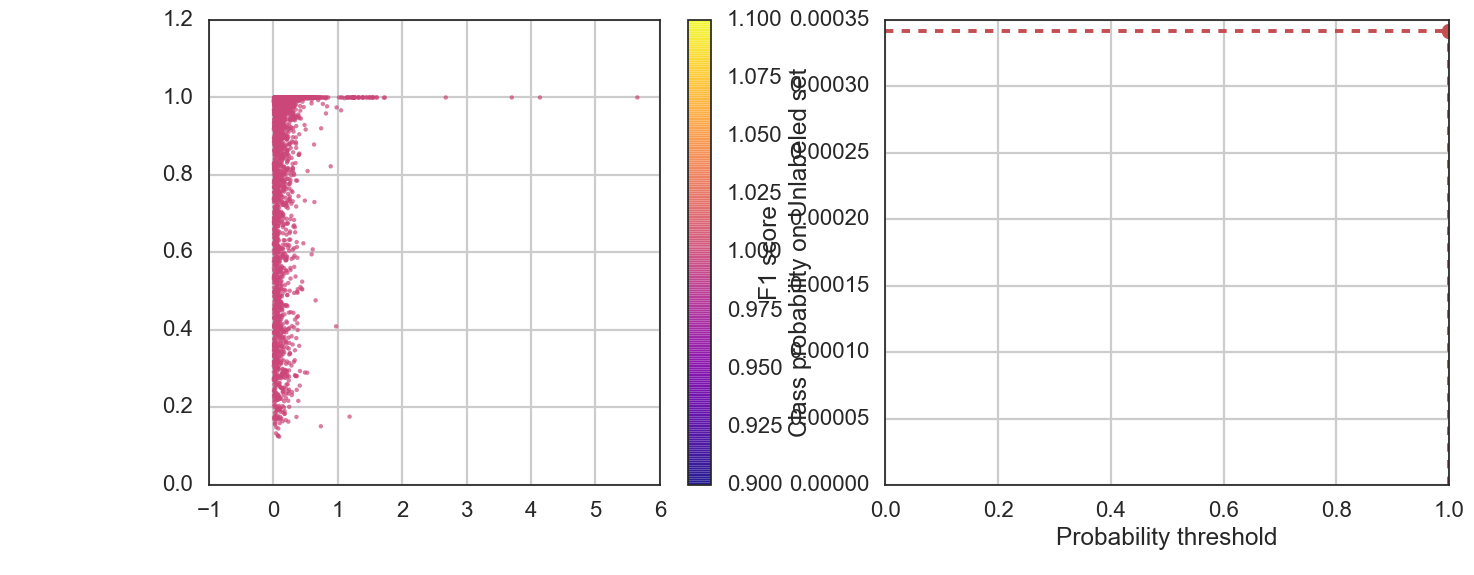

0.000341997264022 1.0
EB
pos/neg: 158 / 2766
Amount of labeled samples: 79


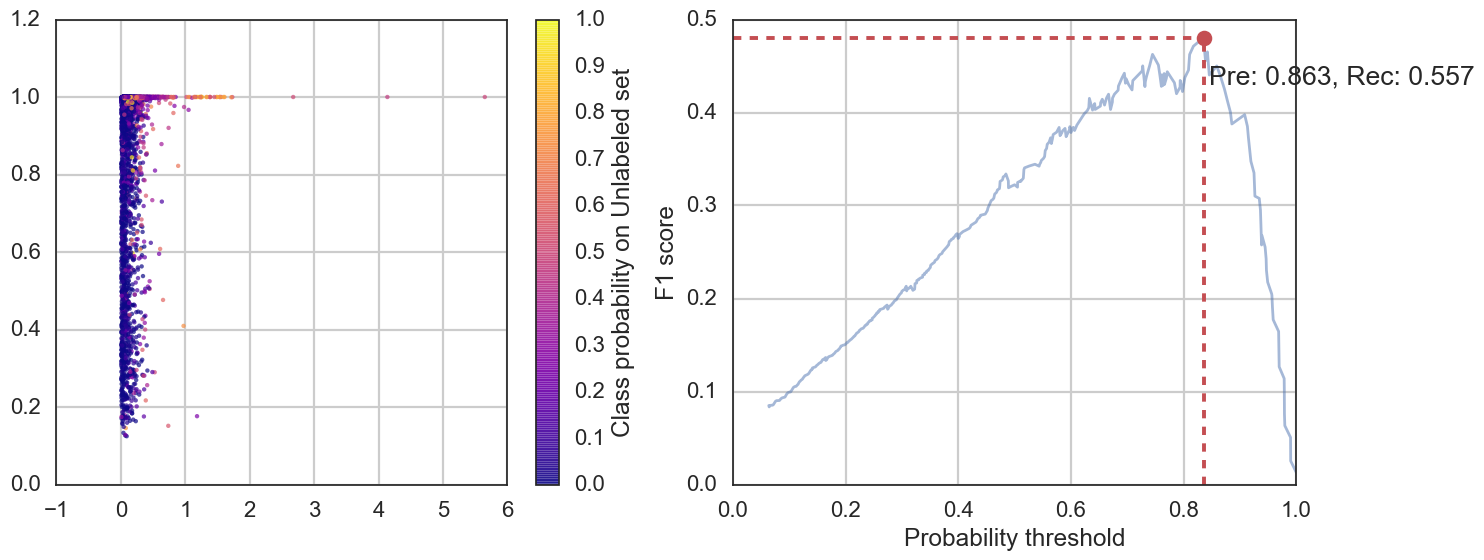

0.862745098039 0.556962025316
LPV
pos/neg: 3 / 2921
Amount of labeled samples: 1


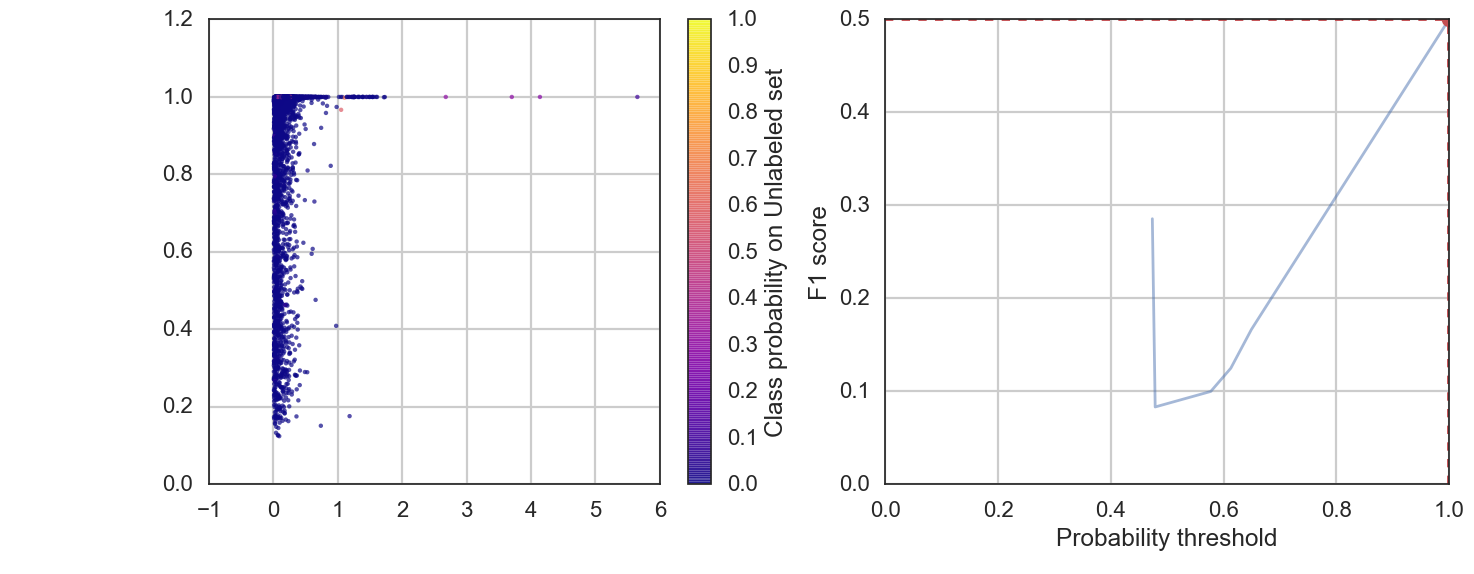

1.0 0.5
MISC
pos/neg: 4 / 2920
Amount of labeled samples: 2


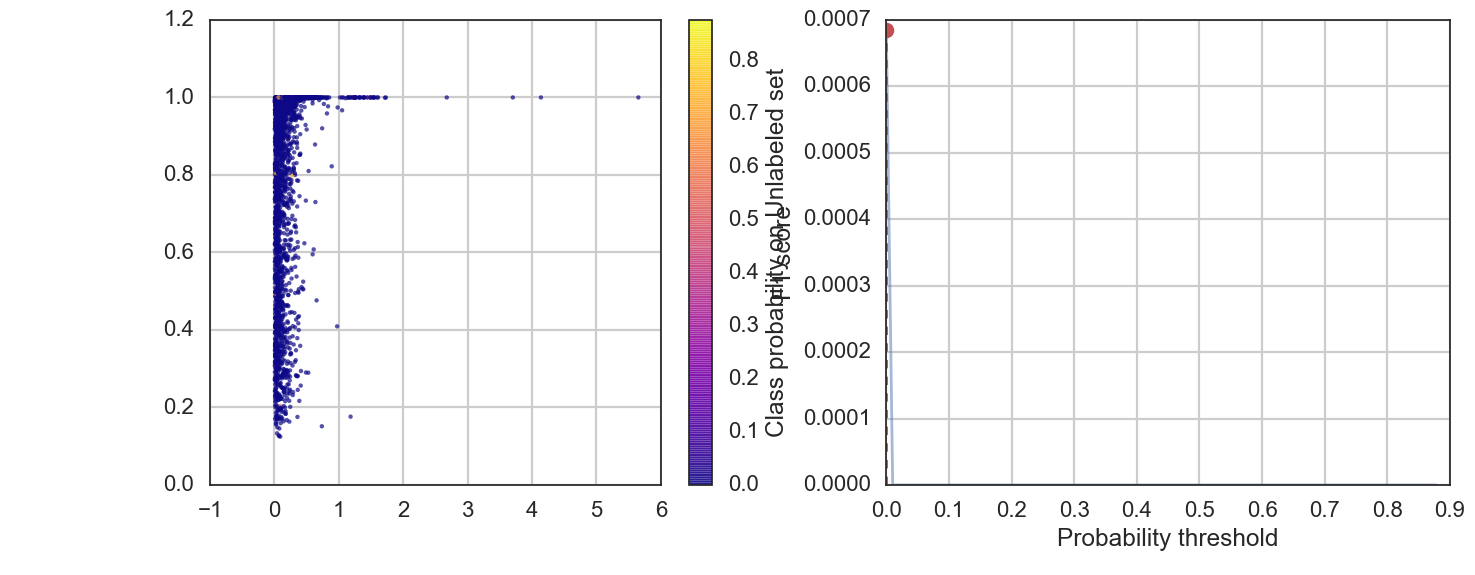

0.000684462696783 1.0
NV
pos/neg: 146 / 2778
Amount of labeled samples: 73


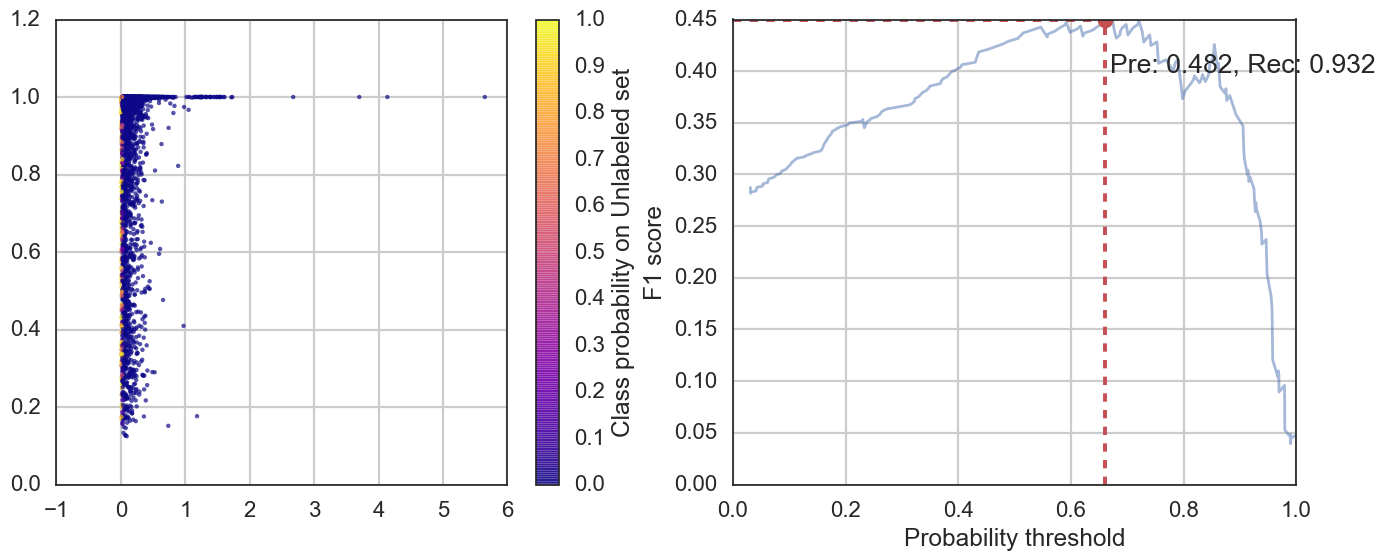

0.482269503546 0.931506849315
QSO
pos/neg: 2333 / 591
Amount of labeled samples: 1166


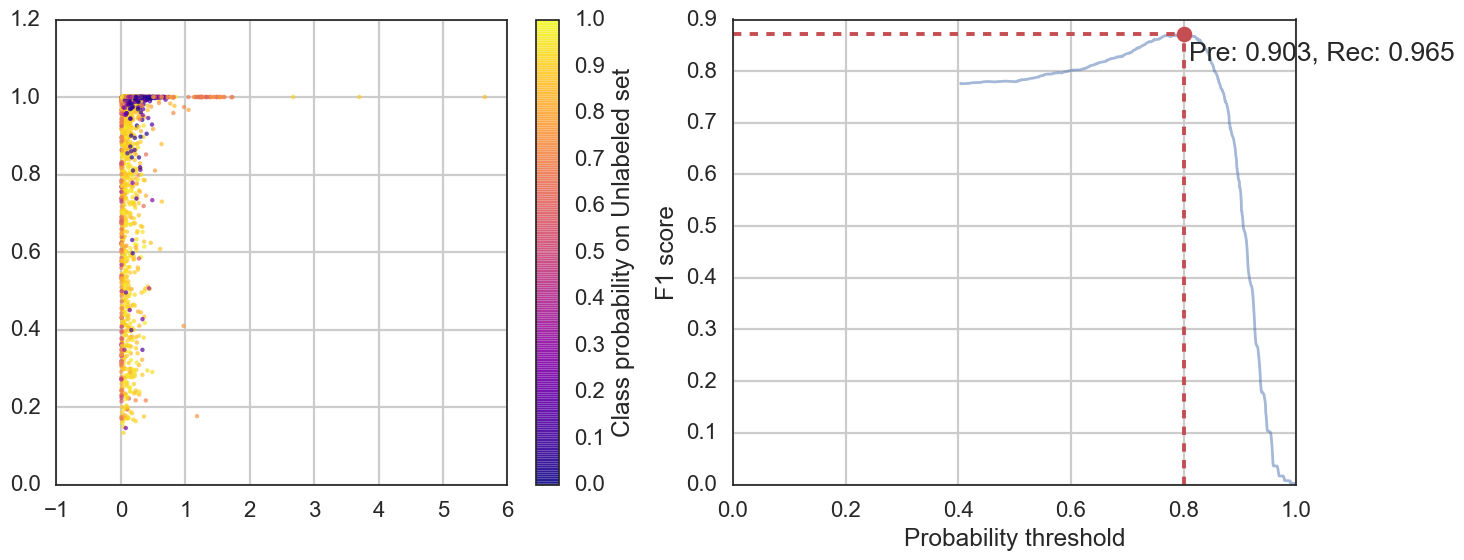

0.902967121091 0.964867180805
ROTVAR
pos/neg: 8 / 2916
Amount of labeled samples: 4


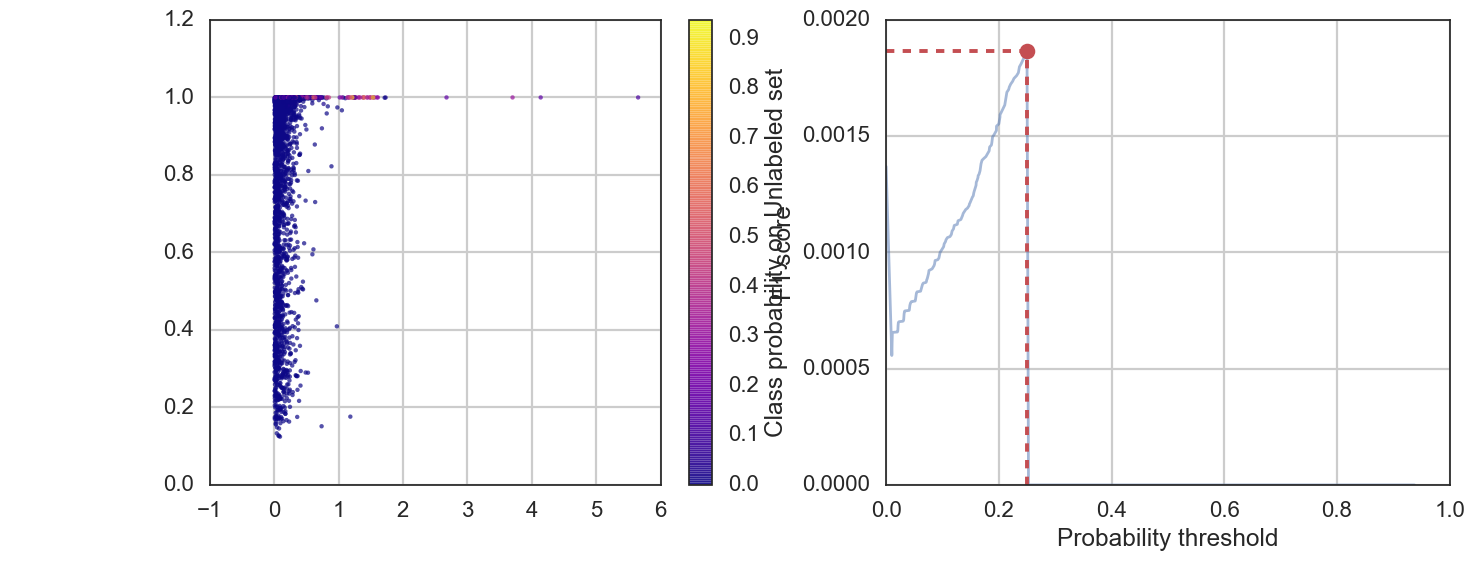

0.00746268656716 0.25
RRLYR
pos/neg: 195 / 2729
Amount of labeled samples: 97


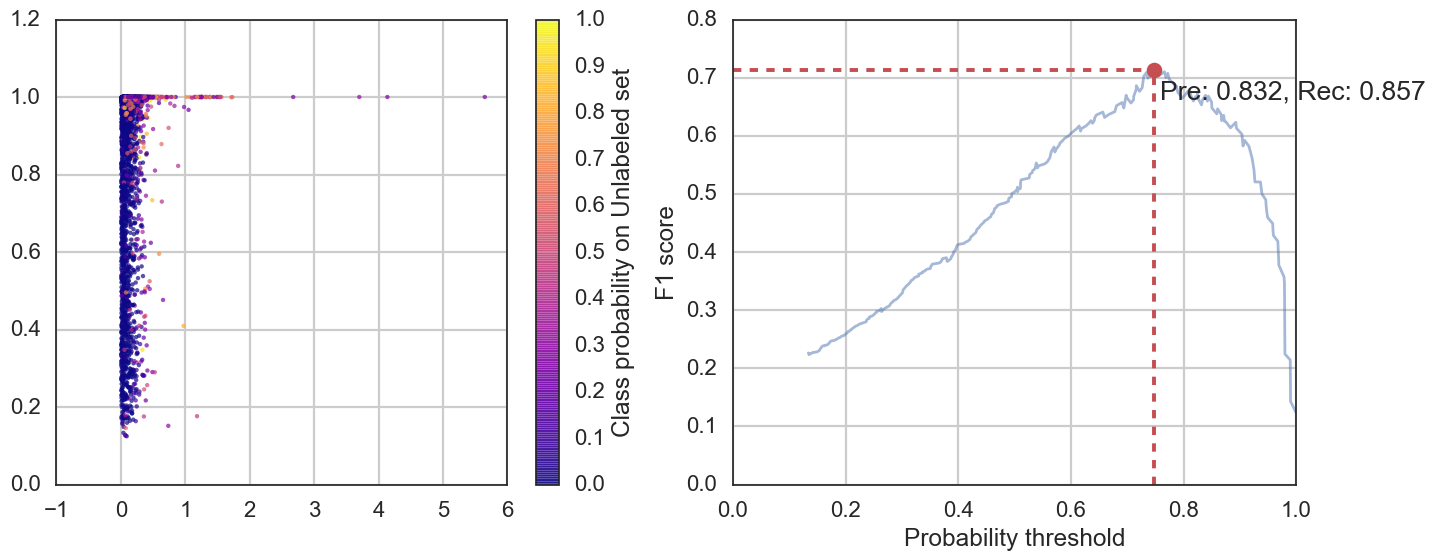

0.831683168317 0.857142857143
SNe
pos/neg: 10 / 2914
Amount of labeled samples: 5


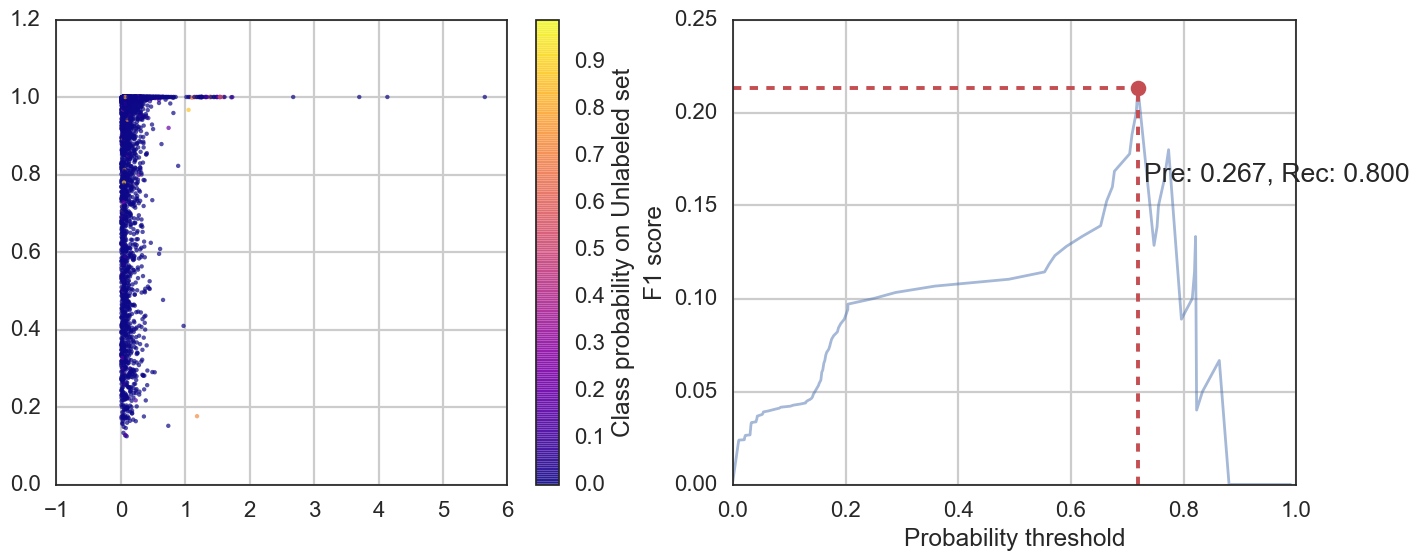

0.266666666667 0.8
ZZ
pos/neg: 2 / 2922
Amount of labeled samples: 1


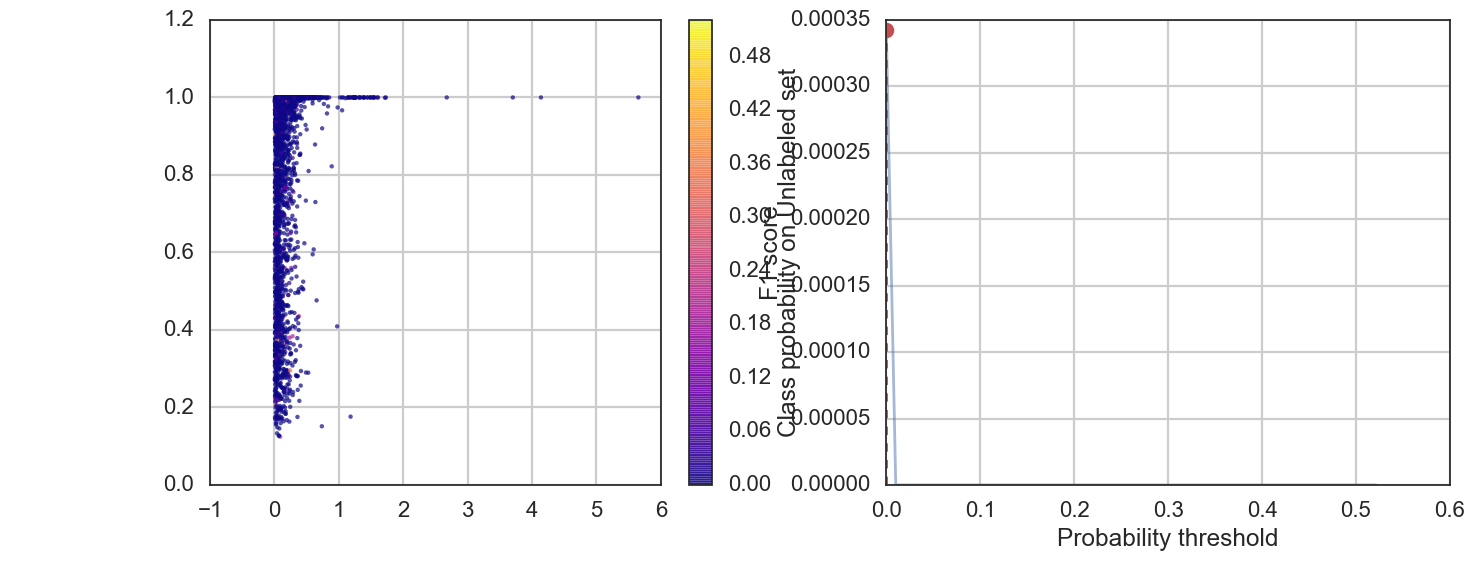

0.000342114266165 1.0


In [266]:
for i,clas in enumerate(lb.classes_):
    print clas
    bagging_PU(X_var, y_bin[:,i], known_labels_ratio=.5, K=150)
    #time.sleep(1)